<h1><u>Predicting Survival with the Titanic Dataset</u></h1>

<h2><i>Task at Hand:</i></h2>

<strong>Using the Titanic dataset, predict 'Survived' based on a number of characteristics about the passenger.  Predict with an accuracy of .80 using a classifier algorithm.

# Step 1. Imports

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
%matplotlib inline

style.use('seaborn')

pd.options.display.max_columns = None

# Step 2. Get the data

In [2]:
train_original = pd.read_csv("../data/raw/train.csv")
test_original = pd.read_csv("../data/raw/test.csv")

In [3]:
train_original.shape

(891, 12)

In [4]:
test_original.shape

(418, 11)

Let's keep the original DataFrames intact and instead work on copies of the data.

In [5]:
train = train_original.copy()
test = test_original.copy()

# Step 3. Feature Engineering

## Step 3a. Peek at the data using .head(), .describe(), and .info()

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train.describe() # Gives us summary statistics of our numerical variables.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Step 3b. Ask questions. Try to see how the data may correlate to survival rate.

<ul>
    <li><strong>Passenger Class</strong> probably has something to do with the survival rate.  First class passengers may have had preferential treatment.</li>
    <li><strong>Name</strong> might not be immediately useful, unless we transform it somehow.  Perhaps we can strip the person's title?</li>
    <li><strong>Sex</strong> probably has a high correlation with survival rate, as women were likely given preferential treatment.</li>
    <li><strong>Age</strong> is tricky.  On one hand, young people might be more likely to survive (think of the "women and children" saying!), but they may have not lasted very long as they are likely weaker (especially kids under 5 years old).</li>
    <li>The <strong>SibSp/Parch</strong> survival rate is also not so intuitive.</li>
    <li><strong>Ticket number</strong> probably holds some keys into survival rate, because ticket numbers might indicate a passenger's location at the time of the collision.</li>
    <li><strong>Fare</strong> is probably not useful, but we will look into it.</li>
    <li><strong>Cabin</strong> would probably be useful, but it looks like we are missing a lot of values.</li>
    <li><strong>Embarked</strong> is also probably not useful, but again, we will see how it correlates with Survived!</li>

## Step 3c. Transform columns to make them more useful.

### Concatenate the DataFrames

Concatenating the train and test DataFrames ensure that any column transformations will be applied to both.

In [9]:
# Add a dummy column to test DF so that train & test have the same dimensions.
test['Survived'] = -8888

In [10]:
# Concat the DFs.  This creates a new DF altogether using COPIES of the two component DFs.
data = pd.concat([train, test])

In [11]:
print('train shape: {0}\ntest shape: {1}\nconcatenated data shape: {2}'.format(train.shape, test.shape, data.shape))

train shape: (891, 12)
test shape: (418, 12)
concatenated data shape: (1309, 12)


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null int64
Ticket         1309 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


### Transformations

#### Name

It looks like we can extract a couple useful things from this column.  Let's create a new column that contains the passenger's title. Before we do any transformations, we need to ensure there are no "NaN" values in the column.  In the table above, we can see that there are no missing 'Name' values.

##### Impute Nulls

In [13]:
data.Name.isnull().sum()

0

No nulls to worry about!

##### Extract Useful Parts

In [14]:
# Build a function to extract title:
def extract_title(name):
    title = re.search(' ([A-Z][a-z]+)\.', name).group(1)
    return title


# Build a function that transforms a DF using the above 2 functions.
def transform_name(df):
    df['Title'] = df.Name.apply(extract_title)
    df.drop(['Name'], axis = 1, inplace=True) # drops the Name column, which has served its purpose.
    return df

In [15]:
transform_name(data)

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,0,1,3,male,1,0,A/5 21171,Mr
1,38.0,C85,C,71.2833,0,2,1,female,1,1,PC 17599,Mrs
2,26.0,NaN,S,7.9250,0,3,3,female,0,1,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,0,4,1,female,1,1,113803,Mrs
4,35.0,NaN,S,8.0500,0,5,3,male,0,0,373450,Mr
5,NaN,NaN,Q,8.4583,0,6,3,male,0,0,330877,Mr
6,54.0,E46,S,51.8625,0,7,1,male,0,0,17463,Mr
7,2.0,NaN,S,21.0750,1,8,3,male,3,0,349909,Master
8,27.0,NaN,S,11.1333,2,9,3,female,0,1,347742,Mrs
9,14.0,NaN,C,30.0708,0,10,2,female,1,1,237736,Mrs


#### Title

In [16]:
data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

That's a lot of redundant titles.  Let's condense them:

In [17]:
title_dict = {'Title': {'Mlle': 'Miss', 'Ms': 'Miss', 'Don': 'UM', 'Rev': 'Special',
                        'Dr': 'Special', 'Mme': 'Mrs', 'Major': 'Special', 'Lady': 'UW',
                       'Sir': 'UM', 'Col': 'Special', 'Capt': 'Special', 'Countess': 'UW',
                        'Jonkheer': 'UM', 'Dona': 'UW'}} # "UW" here means "upper class woman"

data.replace(title_dict, inplace=True)

In [18]:
data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'UM', 'Special', 'UW'], dtype=object)

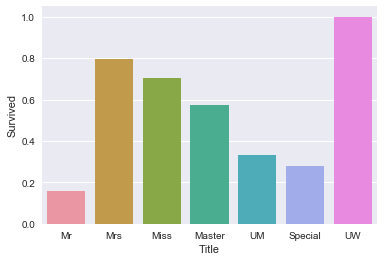

In [19]:
df = train.copy()
transform_name(df)
df.replace(title_dict, inplace=True)

sns.barplot(x='Title', y='Survived', data=df, ci=None);

Looks promising!

#### Fare

##### Impute Missing Values

In [21]:
data[data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
152,60.5,NaN,S,NaN,0,1044,3,male,0,-8888,3701,Mr


Our first missing value! Let's fill it with the median Fare of the passengers embarking from Southhampton.

In [22]:
age_fillna = data.groupby('Embarked').Fare.transform('median')

In [23]:
data['Fare'].fillna(age_fillna, inplace=True)

##### Discretize the Values

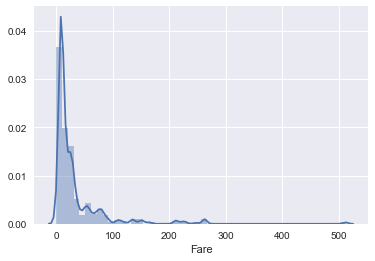

In [24]:
sns.distplot(data['Fare']);

We have a wide range of values for fare.  We will transform this feature by cutting the values into 4 separate categories: very low, low, high, and very high.

In [25]:
data['Fare_Class'] = pd.qcut(data.Fare, 4, labels=['very_low', 'low', 'high', 'very_high'])

In [26]:
data.drop('Fare', axis=1, inplace=True)

In [27]:
data.head()

,Age,Cabin,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fare_Class
0,22.0,NaN,S,0,1,3,male,1,0,A/5 21171,Mr,very_low
1,38.0,C85,C,0,2,1,female,1,1,PC 17599,Mrs,very_high
2,26.0,NaN,S,0,3,3,female,0,1,STON/O2. 3101282,Miss,low
3,35.0,C123,S,0,4,1,female,1,1,113803,Mrs,very_high
4,35.0,NaN,S,0,5,3,male,0,0,373450,Mr,low


Awesome.  Let's move on!

#### Ticket

For simplicity, let's just remove this feature.

In [28]:
data.drop('Ticket', axis=1, inplace=True)

#### Cabin

It looks like our cabin values have at least one useful feature, which is the leading letter. Let's transform the feature to just take that value.

##### Imputing Nulls

First, let's fill in the nulls (which likely mean that the passenger didn't have a cabin at all!)

In [29]:
data.Cabin.fillna('X', inplace=True)

In [30]:
data.head()

,Age,Cabin,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Fare_Class
0,22.0,X,S,0,1,3,male,1,0,Mr,very_low
1,38.0,C85,C,0,2,1,female,1,1,Mrs,very_high
2,26.0,X,S,0,3,3,female,0,1,Miss,low
3,35.0,C123,S,0,4,1,female,1,1,Mrs,very_high
4,35.0,X,S,0,5,3,male,0,0,Mr,low


Now we'll transform the feature.

In [31]:
data['Cabin'] = data.Cabin.apply(lambda x : x[0])

In [32]:
data.head()

,Age,Cabin,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Fare_Class
0,22.0,X,S,0,1,3,male,1,0,Mr,very_low
1,38.0,C,C,0,2,1,female,1,1,Mrs,very_high
2,26.0,X,S,0,3,3,female,0,1,Miss,low
3,35.0,C,S,0,4,1,female,1,1,Mrs,very_high
4,35.0,X,S,0,5,3,male,0,0,Mr,low


#### Age Transformation

##### Imputing Nulls

In [33]:
data.Age.isnull().sum()

263

We have quite a few null values here.  We have to deal with these somehow before feeding the data to our ML algorithm. Since we have 263 null values, we probably shouldn't just delete them. Let's see if we can impute their values.

In [34]:
data[data['Age'].isnull()].sample(10) # Let's see how we might impute the values.

,Age,Cabin,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Fare_Class
560,NaN,X,Q,0,561,3,male,0,0,Mr,very_low
196,NaN,X,Q,0,197,3,male,0,0,Mr,very_low
790,NaN,X,Q,0,791,3,male,0,0,Mr,very_low
303,NaN,E,Q,0,304,2,female,0,1,Miss,low
127,NaN,X,Q,0,1019,3,female,2,-8888,Miss,high
351,NaN,C,S,0,352,1,male,0,0,Mr,very_high
727,NaN,X,Q,0,728,3,female,0,1,Miss,very_low
464,NaN,X,S,0,465,3,male,0,0,Mr,low
121,NaN,X,Q,0,1013,3,male,1,-8888,Mr,very_low
420,NaN,X,C,0,421,3,male,0,0,Mr,very_low


What other characteristic might give us some insight into their age?<br>
Probably 'Title'.

In [35]:
medianAge_byTitle = data.groupby('Title')['Age'].transform('median')

In [36]:
# Fill in the missing values with the median Age of their 'Title' grouping
data.Age.fillna(medianAge_byTitle, inplace=True) 

##### Discretizing

Similar to what we did with Fare.

In [37]:
bins = [0, 2, 5, 10, 14, 18, 25, 35, 45, 55, 65, 120]
labels = ['Baby','YoungChild','Child','PreTeen','Teen',
          'YoungAdult','Adult','OldAdult','OlderAdult',
          'YoungElderly','Elderly']  # Don't worry about the label names too much. They will be encoded shortly.

data['Age'] = pd.cut(data['Age'], bins, labels=labels)

## Step 3d. Feature Encoding

We need to translate our categorical ('string') features into something the ML algorithm can understand.<br>
Here, we use Panda's get_dummies() function to use one-hot-encoding on our categorical features.  Essentially, one-hot-encoding converts our string values into binary 0's or 1's.  It is a bit more complex than that, so try googling it!

In [38]:
to_encode = ['Age', 'Cabin', 'Embarked', 'Sex', 'Title', 'Fare_Class']

data = pd.get_dummies(data=data, columns=to_encode, drop_first=True)

# Step 4. Resplit the data

In [39]:
train = data.iloc[:891]
test = data.iloc[891:]

We now need to split our train set by column- X is all the independent variables (Features) and y is the dependent variable (Label).

In [40]:
X = train.drop(['PassengerId', 'Survived'], axis=1)
y = train['Survived']

In [41]:
test_passenger_ids = test['PassengerId'] # Save this for our submission later!
test_features = test.drop(['PassengerId', 'Survived'], axis=1)

# Step 5. Modeling

In [42]:
from sklearn.linear_model import LogisticRegression # MODEL 1
from sklearn.neighbors import KNeighborsClassifier # MODEL 2
from sklearn.tree import DecisionTreeClassifier # MODEL 3
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform

## Step 5a. Create Hyperparameter ranges for our RandomizedSearchCV

RandomizedSearchCV does a few things for us.  First, it randomly splits our data into n "folds", and trains the model on n-1 of the folds.  Then, it tests each model on the last fold, and produces a score.  It also lets us train the models using a range of hyperparameter settings.  It will tell us which hyperparameter settings provided the best score.

Here, we create the hyperparameter ranges to test out.

In [43]:
lr_param_dist = {'penalty': ['l1', 'l2'],
                 'C': uniform(loc=0, scale=4)}

kn_param_dist = {'n_neighbors': range(1,31),
                'weights': ['uniform', 'distance']}

dt_param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

Now, instantiate our models:

In [44]:
lr = LogisticRegression()
kn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

...and instantiate our RandomizedSearchCVs based on those models:

In [45]:
lr_cv = RandomizedSearchCV(lr, lr_param_dist, cv=5)
kn_cv = RandomizedSearchCV(kn, kn_param_dist, cv=5)
dt_cv = RandomizedSearchCV(dt, dt_param_dist, cv=5)

#### Logistic Regression

In [46]:
lr_cv.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a14f779e8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [47]:
# The best_params_ method tells us which hyperparameters worked best
lr_cv.best_params_

{'C': 1.9547916803253425, 'penalty': 'l2'}

In [50]:
# The best_score_ method tells us our best score using this model with the above hyperparameters.
lr_cv.best_score_

0.813692480359147

#### K-Nearest Neighbors

In [51]:
kn_cv.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_neighbors': range(1, 31), 'weights': ['uniform', 'distance']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [52]:
kn_cv.best_params_

{'weights': 'uniform', 'n_neighbors': 18}

In [53]:
kn_cv.best_score_

0.8215488215488216

#### Decision Tree

In [54]:
dt_cv.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': [3, None], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a14f77ef0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a14f77c50>, 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [55]:
dt_cv.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 3}

In [56]:
dt_cv.best_score_

0.8080808080808081

# Step 6. Create our final CSVs for Submission

In [57]:
lr = LogisticRegression(C=1.9547916803253425, penalty='l2')  # Instantiate the best tuned LR model
lr.fit(X,y)  # Fit it to our data
test_predictions = lr.predict(test_features)  # Predict the results from our test set
submissionLR = pd.DataFrame({'PassengerId': test_passenger_ids,
                           'Survived': test_predictions}) # Create a submission DataFrame w/ just P.I.D and 'Survived'
submissionLR.to_csv('TitanicSubmissionsLR.csv', index=False) # Export to csv!

In [58]:
kn = KNeighborsClassifier(weights='uniform', n_neighbors=9)
kn.fit(X,y)
test_predictions = kn.predict(test_features)
submissionKN = pd.DataFrame({'PassengerId': test_passenger_ids,
                           'Survived': test_predictions})
submissionKN.to_csv('TitanicSubmissionsKN.csv', index=False)

In [59]:
dt = DecisionTreeClassifier(criterion='gini',
                            max_depth=None,
                            max_features=6,
                            min_samples_leaf=6)
dt.fit(X,y)
test_predictions = dt.predict(test_features)
submissionDT = pd.DataFrame({'PassengerId': test_passenger_ids,
                           'Survived': test_predictions})
submissionDT.to_csv('TitanicSubmissionsDT.csv', index=False)